In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from fredapi import Fred
fred = Fred(api_key="your_api_key")

start = '1948-01'
end = '2022-01'

unr = fred.get_series('UNRATE',  observation_start=start)
unr.index.freq = unr.index.inferred_freq
unr.name = 'Unemployment'
recessions = fred.get_series('USREC',  observation_start=start, observation_end=end)
recessions.name='recessions'
df = pd.merge(unr, recessions, how='outer', left_index=True, right_index=True)
df = df.fillna(value=0)
df.index.freq = df.index.inferred_freq
dates = df.index._mpl_repr()


indpr = fred.get_series('INDPRO',  observation_start=start, observation_end=end)
indpr.index.freq = indpr.index.inferred_freq
indpr.name = 'Industrial production'
indpr = indpr.to_frame()

## Regime-switching models

### Motivation

+ empirically, economic contractions are steeper and more short-lived than expansions

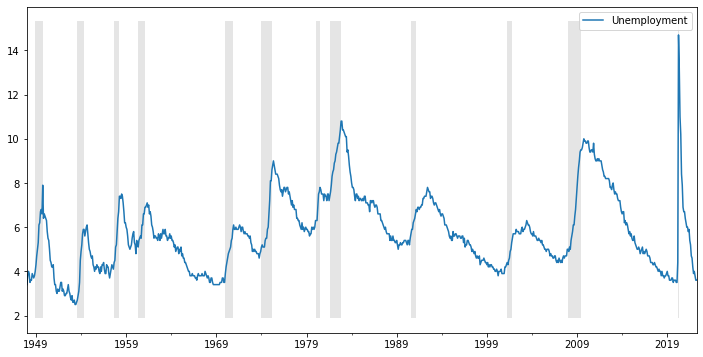

In [2]:
fig, ax = plt.subplots(figsize=(12,6))

df[['Unemployment']].plot(ax=ax)
ylim = ax.get_ylim()
ax.fill_between(dates, ylim[0], ylim[1], df[['recessions']].values.flatten(), facecolor='k', alpha=0.1);

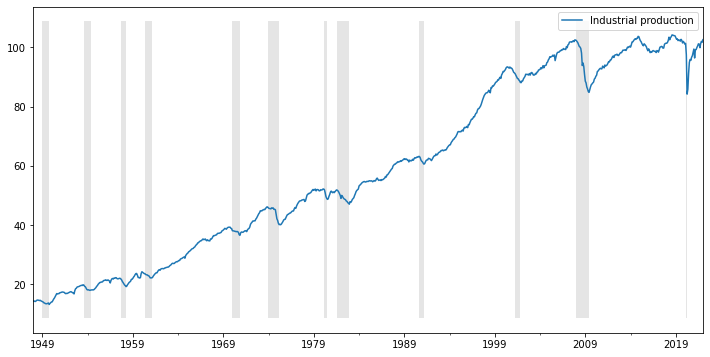

In [3]:
fig2, ax = plt.subplots(figsize=(12,6))

indpr.plot(ax=ax)
ylim = ax.get_ylim()
ax.fill_between(dates, ylim[0], ylim[1], df[['recessions']].values.flatten(), facecolor='k', alpha=0.1);

+ asymmetry between different phases of the business cycle

+ linear models rule out different dynamics of variables during contractions and expansions 

+ contractions are much less common part of the sample
    + trend-cycle decompositions based on linear models are better at representing dynamics during expansions. 

+ non-linear models may be better at capturing the business cycle asymmetry

+ asymmetry may be explained by different propagation mechanism in contractions vs expansions, or by asymmetry in the shocks
    + capacity constraints, monopoly power, downward vs upward price/wage stickiness, etc

### Regime-switching AR(p) model

$$
\begin{align}
\alpha(L) \left( z_t - \mu_t \right) &= \varepsilon_t, \;\;\; \varepsilon_t \sim \mathcal{N} \left( 0, \;\mathbf{\sigma}^2_{t}\right) \\
\\
\mu_t = \mu_0 &+ \mu_1 I(S_t = 1)
\\
\\
\sigma^2_t = \sigma^2_0 &+ \sigma^2_1 I(S_t = 1)
\\\\
S_t &= 0,1 \;\; (\text{expansion, contraction})
\end{align}
$$

* if $S_t$ is known (observed) this model can be estimated in the usual way by MLE or OLS using dummies


$$
\begin{align}
\ell(\boldsymbol \theta | \mathbf{z}, \mathbf{S}) & = \sum_{t=1}^{T}\ln(p(z_t | Z_{t-1}, S_t, S_{t-1}, ..., S_{t-p}))
\\\\
& \text{if p = 1}\\\\
\ln(p(z_t | Z_{t-1}, S_t, S_{t-1})) &= -\frac{1}{2}\ln(2 \pi \sigma^2_t) - \frac{1}{2 \sigma^2_t}\left( (z_t - \mu_t) - \alpha_1 (y_{t-1} - \mu_{t-1})\right)
\end{align}
$$

* not very appealing as this assumes regime switches are deterministic - can be predicted

* if $S_t$ is unobserved, we cannot condition on $ S_t, S_{t-1}, ..., S_{t-p}$, and have to work with


$$
\begin{align}
\ell(\boldsymbol \theta | \mathbf{z}) & = \sum_{t=1}^{T}\ln(p(z_t | Z_{t-1}))
\end{align}
$$

+ integrate out $S_t, S_{t-1}$ from the joint density $p(z_t, S_t, S_{t-1} | Z_{t-1})$ by summing over all possible values of $S_t$ and $S_{t-1}$ 

$$
\begin{align}
p(z_t | Z_{t-1}) &= \sum_{S_t = 0}^{1}\sum_{S_{t-1} = 0}^{1}p(z_t, S_t, S_{t-1} | Z_{t-1})
\end{align}
$$

using

$$
p(z_t, S_t, S_{t-1} | Z_{t-1}) = p(z_t |  S_t, S_{t-1}, Z_{t-1})\operatorname{Pr}(S_t, S_{t-1} | Z_{t-1})
$$

we have

$$
\begin{align}
p(z_t | Z_{t-1}) &= \sum_{S_t = 0}^{1}\sum_{S_{t-1} = 0}^{1} p(z_t |  S_t, S_{t-1}, Z_{t-1})\operatorname{Pr}(S_t, S_{t-1} | Z_{t-1})
\end{align}
$$

* $p(z_t |  S_t, S_{t-1}, Z_{t-1})$ computed as before (for known $S_t$)

__Hamilton filter (Hamilton (1989)):__

* assumes time-invariant Markov chain

$$
\begin{align}
\operatorname{Pr}[S_t = i | S_{t-1} = j, S_{t-2} = k, ..., Z_{t-1}] & = \operatorname{Pr}[S_t = i | S_{t-1} = j]\\
&= p_{ij}
\end{align}
$$

* what if $p_{1,1} = 1?$

* restrictions?

$$ p_{0, j} + p_{1, j} = 1 $$

* computes $\operatorname{Pr}(S_t=i, S_{t-1}=j | Z_{t-1})$ iteratively starting with the unconditional probabilities

$$
\begin{align}
\operatorname{Pr}(S_1=0) = \frac{1-p_{11}}{2 - p_{11} - p_{00}}, \;\;\;
\operatorname{Pr}(S_1=1) = \frac{1-p_{00}}{2 - p_{11} - p_{00}}\\
\end{align}
$$

### Markov-switching models in Statsmodels

Two classes of models:
* [markov switching dynamic regression models](https://www.statsmodels.org/stable/examples/notebooks/generated/markov_regression.html)
* [markov switching autoregression models](https://www.statsmodels.org/stable/examples/notebooks/generated/markov_autoregression.html)

__markov-switching dynamic regression models__

$$
z_t = \mu_t + x^{\prime}_t \gamma + y^{\prime}_t \beta_t +  \varepsilon_t, \;\;\; \varepsilon_t \sim \mathcal{N} \left( 0, \;\mathbf{\sigma}^2_{t}\right)
$$

where both $x_t$ and $y_t$ may include lags of $z_t$

+ $z_t$ depends only on the current state (the intercept has 2 possible values for a model with 2 states)

__markov-switching autoregression models__

$$
\begin{align}
z_t &=   \mu_t + x^{\prime}_t \gamma + y^{\prime}_t \beta_t + \sum_{i=1}^{p}\alpha_{i,t}\left( z_{t-i} - \mu_{t-1} + x^{\prime}_{t-i} \gamma + y^{\prime}_{t-i} \beta_{t-i}\right), \;\;\; \varepsilon_t \sim \mathcal{N} \left( 0, \;\mathbf{\sigma}^2_{t}\right) 
\\
\\
&\alpha_t(L) \left( z_t - \mu_t - x^{\prime}_t \gamma - y^{\prime}_t \beta_t \right)  = \varepsilon_t, \;\;\; \varepsilon_t \sim \mathcal{N} \left( 0, \;\mathbf{\sigma}^2_{t}\right) 
\end{align}
$$

+ $z_t$ depends on the current and past states (the intercept has 4 possible values for a model with 2 states when p=1)